In [3]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

# Read the CSV file
df = pd.read_csv("https://raw.githubusercontent.com/tassalor1/Bank-Term-Deposit-Prediction/Virginia's-Branch/Bank-Additional-full.csv")

# Check the shape of the dataframe
print(df.shape)

(41188, 22)


In [4]:
# Check null values
missing = df.isnull().sum()
print(missing)

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
year              0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [5]:
# Check unknown count per column
for col in df.columns:
    if col != 'default':
        unknown_count = df[col].value_counts().get("unknown")
        print(f"{col}: {unknown_count}")

age: None
job: 330
marital: 80
education: 1731
housing: 990
loan: 990
contact: None
month: None
year: None
day_of_week: None
duration: None
campaign: None
pdays: None
previous: None
poutcome: None
emp.var.rate: None
cons.price.idx: None
cons.conf.idx: None
euribor3m: None
nr.employed: None
y: None


In [6]:
# Replacing "unknown" with NaN for all features except 'default'
df[df.columns.difference(['default'])] = df[df.columns.difference(['default'])].replace('unknown', np.nan)

In [7]:
# Remove NaN values from 'marital' and 'job' columns
df = df.dropna(subset=['marital', 'job'])

In [8]:
# Fill NaN values with mode for 'housing' and 'loan' columns
df['housing'].fillna(df['housing'].mode()[0], inplace=True)
df['loan'].fillna(df['loan'].mode()[0], inplace=True)

In [9]:
# Convert the 'education' column to numerical values
education_mapping = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6
}
df['education'] = df['education'].map(education_mapping)

In [10]:
# Encode 'default' column
encoder = LabelEncoder()
df['default'] = encoder.fit_transform(df['default'].astype(str))

In [11]:
# Apply KNNImputer to fill missing values in 'default' column
imputer = KNNImputer(n_neighbors=5)
df['default'] = imputer.fit_transform(df[['default']])


In [12]:
# Round the imputed values to the nearest integer
df['default'] = np.round(df['default']).astype(int)

In [13]:
# Convert the imputed numerical values back to their original category names
df['default'] = encoder.inverse_transform(df['default'])

In [14]:
# Apply KNNImputer to fill missing values in 'education' column
df['education'] = imputer.fit_transform(df[['education']])

In [15]:
# Round the imputed values to the nearest integer
df['education'] = np.round(df['education']).astype(int)

In [16]:
# Convert the imputed numerical values back to their original category names
df['education'] = df['education'].map(dict(zip(range(7), education_mapping)))

In [17]:
# Remove outliers in 'duration' column
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
df = df[(df['duration'] >= lower_bound) & (df['duration'] <= upper_bound)]

In [18]:
# Save cleaned data to a new CSV file
df.to_csv('cleaned_data.csv', index=False)

In [19]:
 df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
year              0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [20]:
sum(df['default']=='unknown')

8236

In [21]:
df['y']

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 39758, dtype: object

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Read the cleaned dataset
#df = pd.read_csv('cleaned_data.csv')

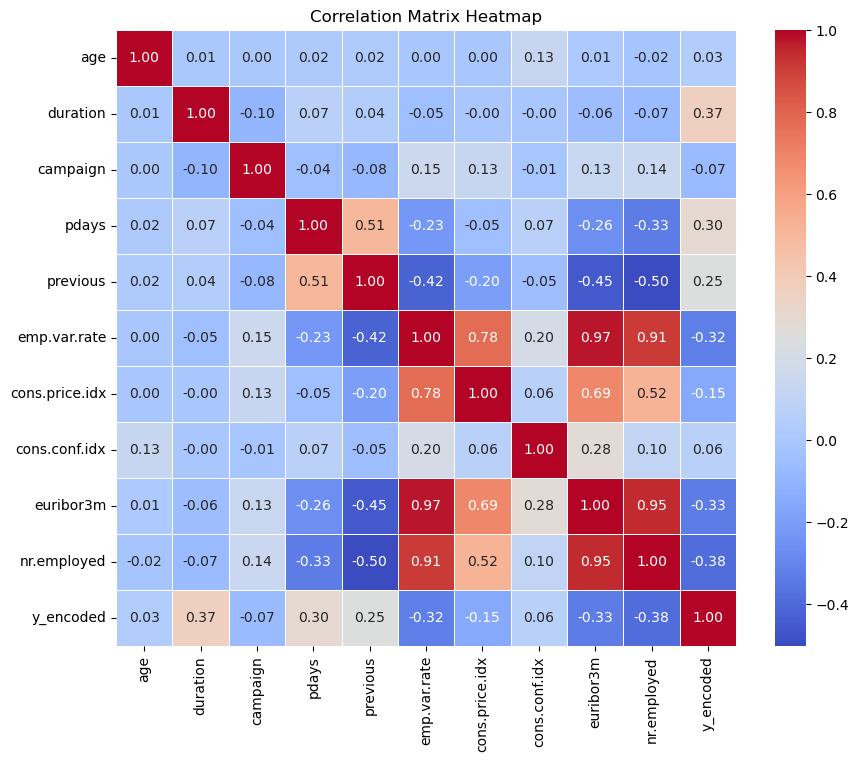

Features with the strongest relationship to the target variable:
nr.employed       0.383736
duration          0.368165
euribor3m         0.332437
emp.var.rate      0.323342
pdays             0.301170
previous          0.249235
cons.price.idx    0.149424
campaign          0.072678
cons.conf.idx     0.063054
age               0.034283
Name: y_encoded, dtype: float64


In [23]:
# Encode the target variable 'y' into numerical values
df['y_encoded'] = df['y'].map({'no': 0, 'yes': 1})

# Calculate correlations between numerical features and 'y'
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
                      'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
correlation_matrix = df[numerical_features + ['y_encoded']].corr()

# Plot correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Identify features with the strongest relationship to the target variable ('y')
target_variable = 'y_encoded'
strongest_correlations = correlation_matrix['y_encoded'].abs().sort_values(ascending=False)[1:]
print("Features with the strongest relationship to the target variable:")
print(strongest_correlations)


In [24]:
import pandas as pd
import scipy.stats as stats

# List of categorical features
categorical_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Perform chi-square analysis for each categorical feature
for feature in categorical_features:
    # Create a contingency table
    contingency_table = pd.crosstab(df[feature], df['y'])
    
    # Perform chi-square test of independence
    chi2, p_value, _, _ = stats.chi2_contingency(contingency_table)
    
    # Print the results
    print(f"Chi-square test of independence for {feature}:")
    print("Chi-square statistic:", chi2)
    print("P-value:", p_value)
    print()


Chi-square test of independence for job:
Chi-square statistic: 1101.7496560691422
P-value: 2.2144283975745114e-230

Chi-square test of independence for marital:
Chi-square statistic: 127.66864078870381
P-value: 1.8928094550127215e-28

Chi-square test of independence for education:
Chi-square statistic: 205.41489644438045
P-value: 1.3346035192157662e-41

Chi-square test of independence for housing:
Chi-square statistic: 8.351390064068939
P-value: 0.0038539237694419576

Chi-square test of independence for loan:
Chi-square statistic: 1.3518765926567666
P-value: 0.24495031611650803

Chi-square test of independence for contact:
Chi-square statistic: 900.8816140622016
P-value: 6.312022457474617e-198

Chi-square test of independence for month:
Chi-square statistic: 3478.7232981994416
P-value: 0.0

Chi-square test of independence for day_of_week:
Chi-square statistic: 21.96533425781835
P-value: 0.00020363000146544831

Chi-square test of independence for poutcome:
Chi-square statistic: 4760.983

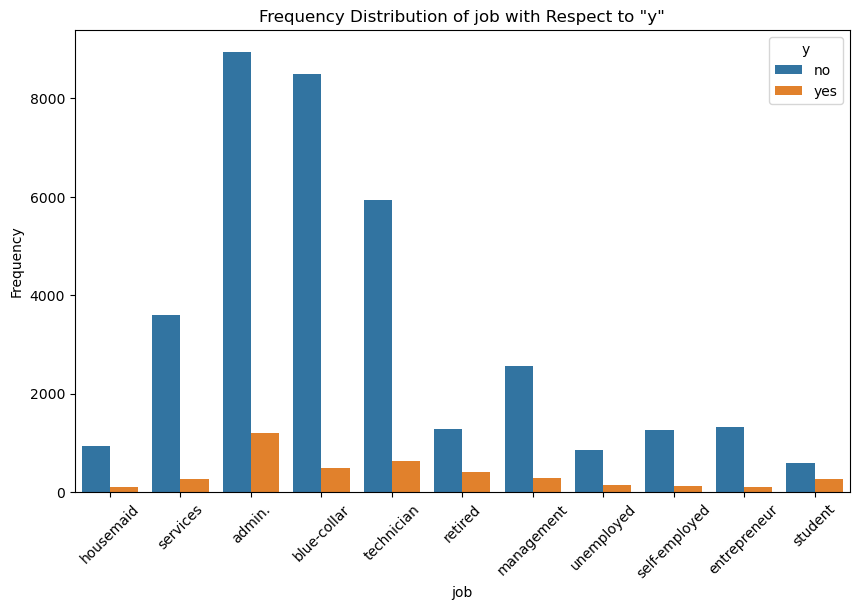

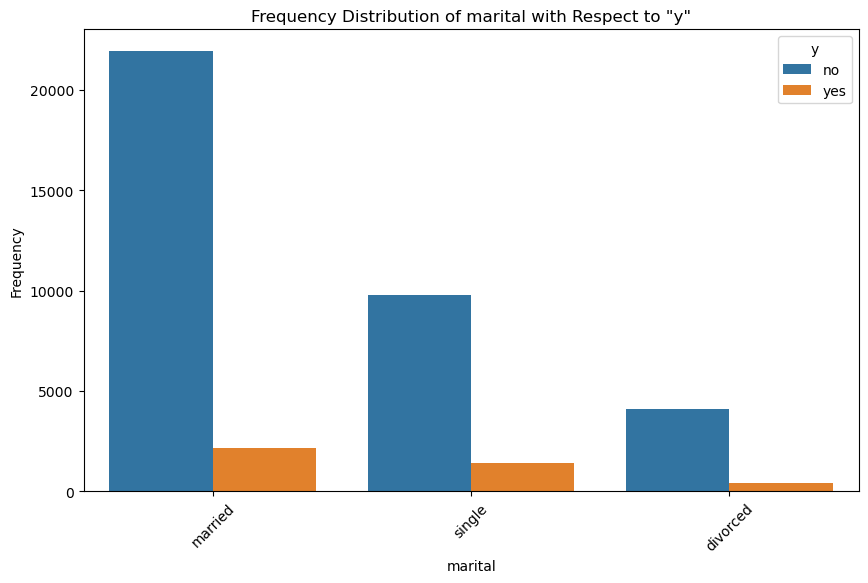

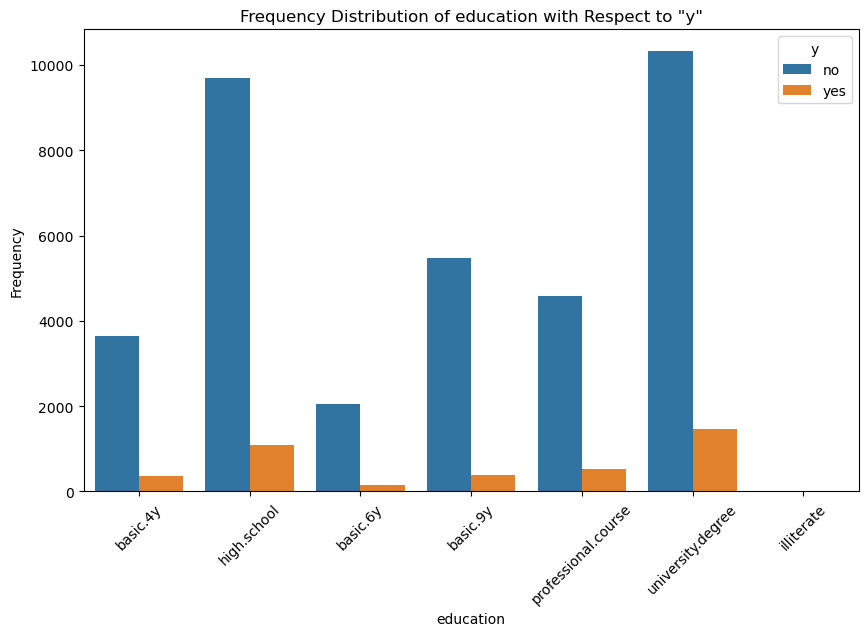

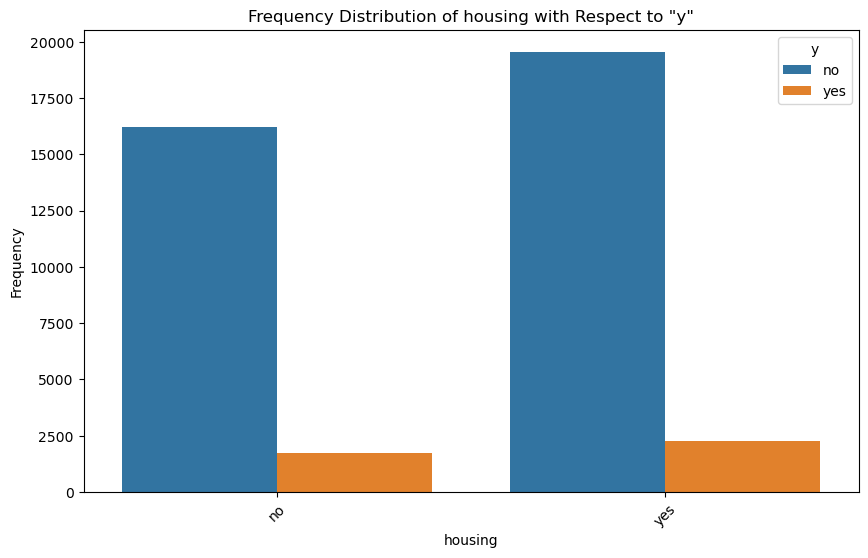

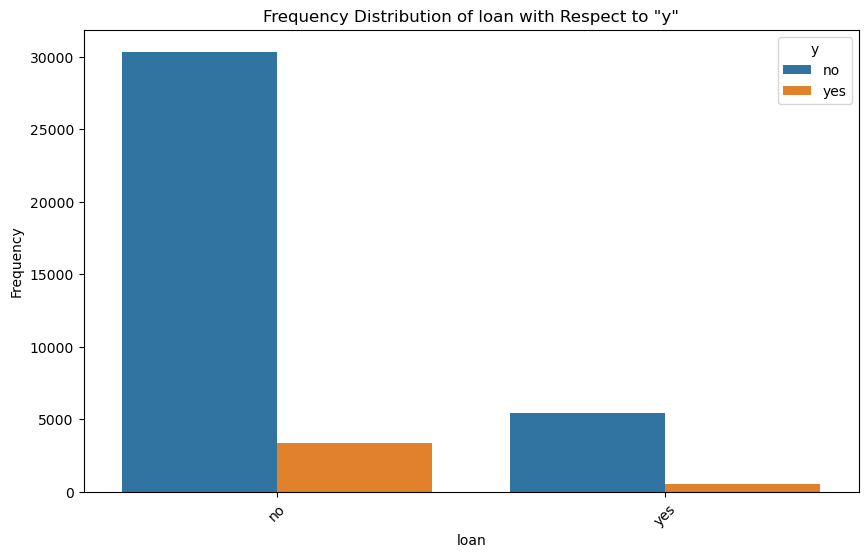

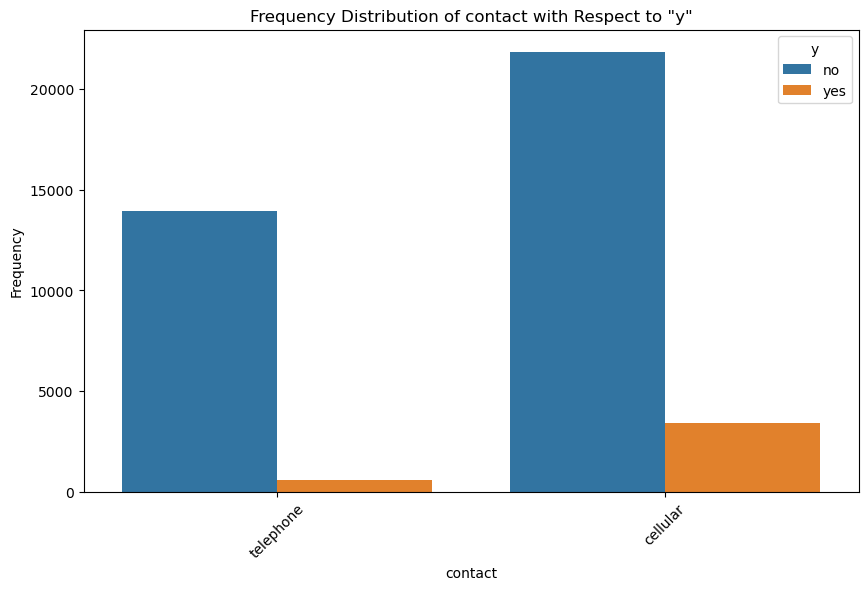

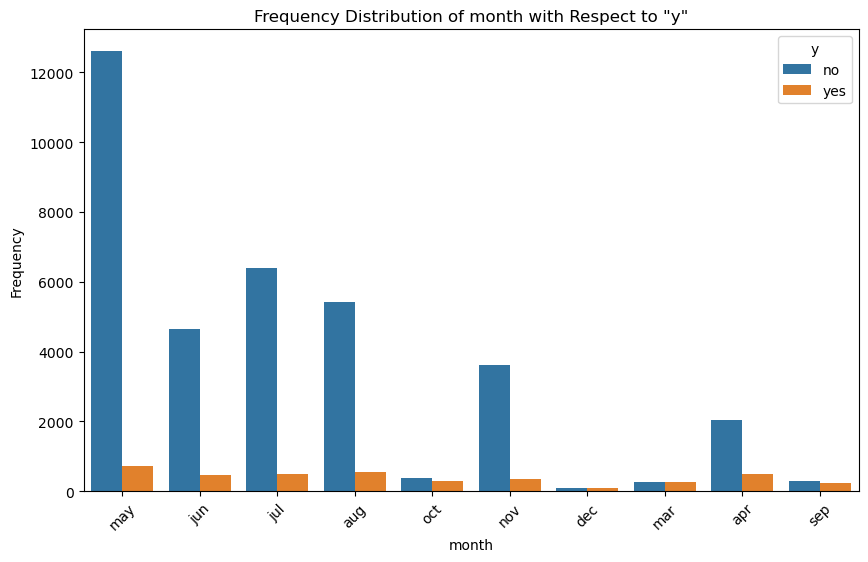

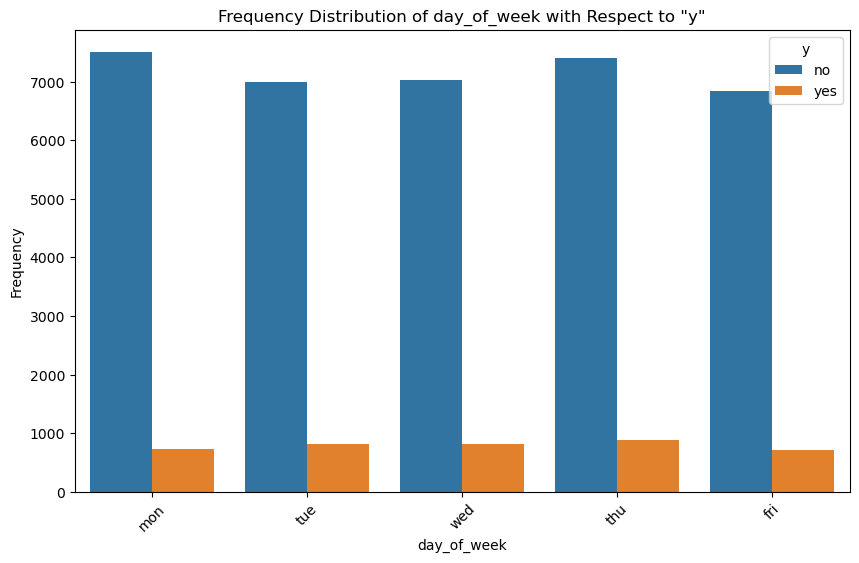

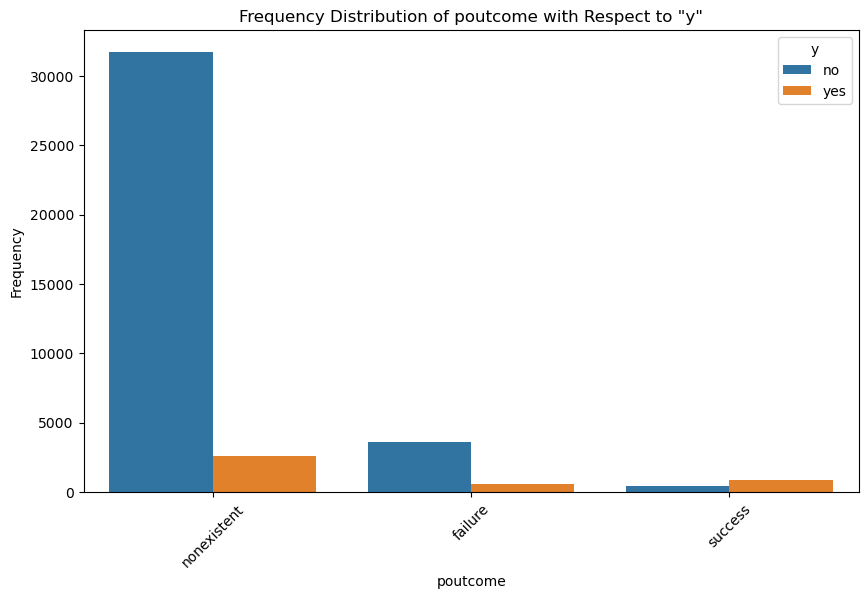

In [25]:
# Plot bar chart of feature frequencies
categorical_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    ax=sns.countplot(data=df, x=feature, hue='y')
    plt.title(f'Frequency Distribution of {feature} with Respect to "y"')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.legend(title='y', loc='upper right')
    
    plt.show()

In [26]:
counts = df['job'].value_counts()
labels = counts.index
sizes = counts.values
yes_counts = df[df['y'] == 'yes']['job'].value_counts()
yes_counts['retired']

403

In [27]:
yes= df['y'].value_counts()
yes_tot_count=yes['yes']
#yes_counts['retired']/yes_tot_count
yes_cnt=df[df['y']=='yes']['y'].count()
yes_cnt

3984

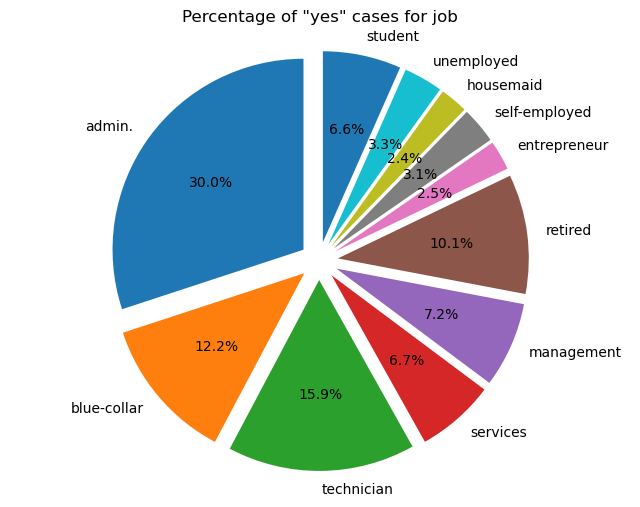

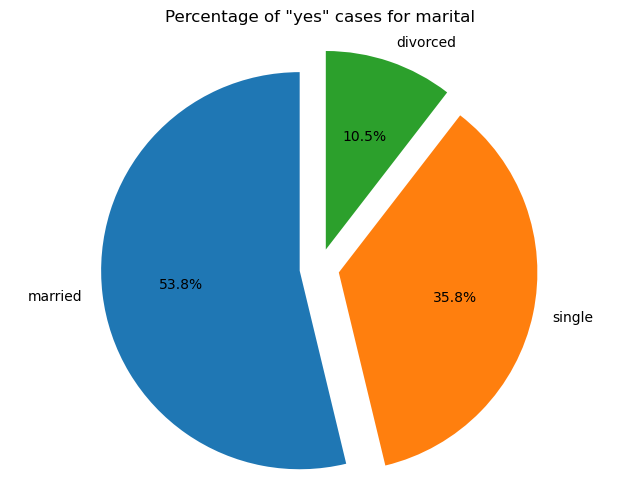

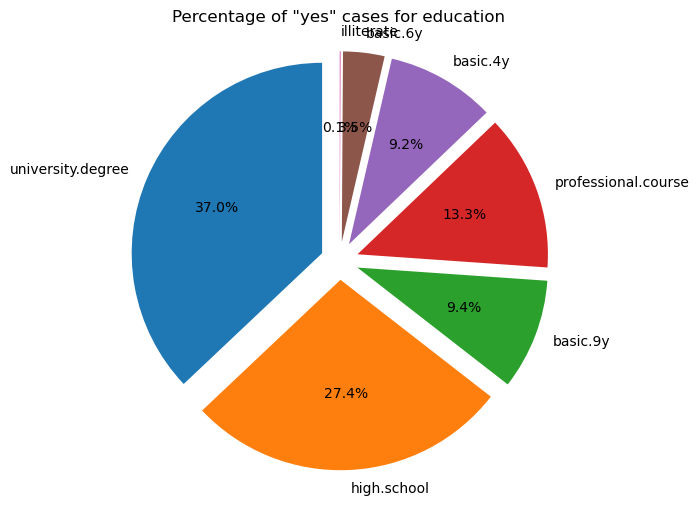

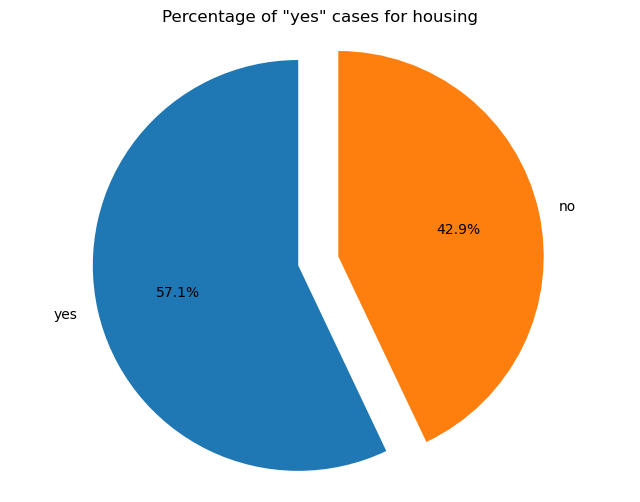

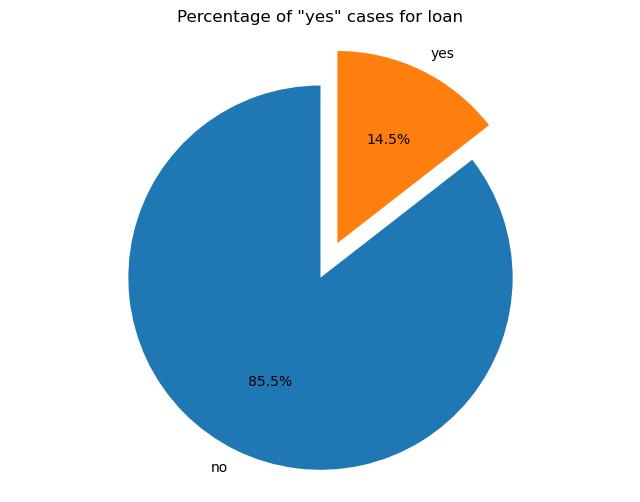

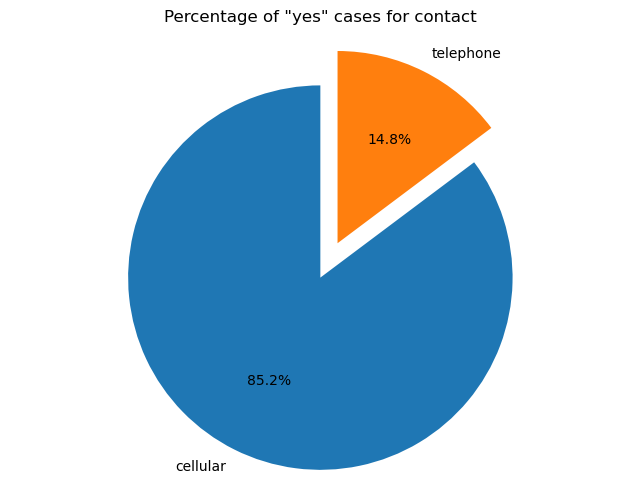

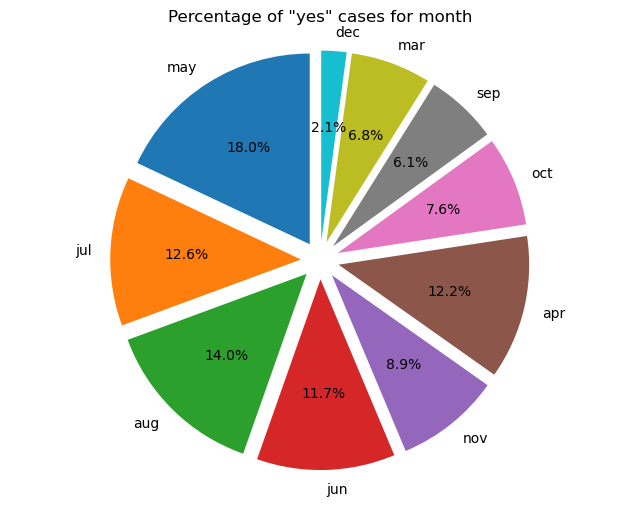

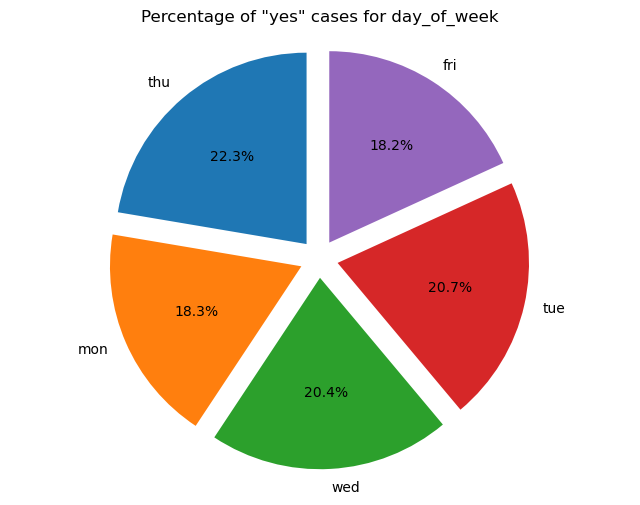

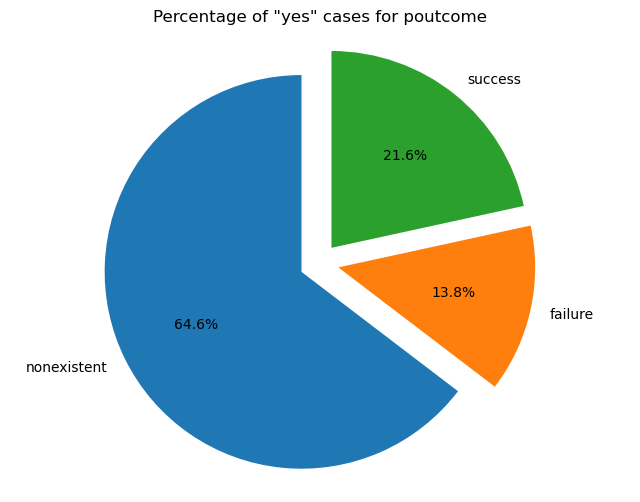

In [28]:
categorical_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
yes_tot_count=df[df['y']=='yes']['y'].count()
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    counts = df[feature].value_counts()
    labels = counts.index
    sizes = counts.values
    yes_counts = df[df['y'] == 'yes'][feature].value_counts()
    yes_counts = yes_counts.reindex(labels, fill_value=0)  # Reindex to match category order
    explode = [0.1 if label in yes_counts else 0 for label in labels]
    percentages = [yes_counts[label] / yes_tot_count * 100 if label in yes_counts else 0 for label in labels]
  
    plt.pie(yes_counts, labels=labels, explode=explode, autopct='%1.1f%%', startangle=90)
    plt.title(f'Percentage of "yes" cases for {feature}')
    plt.axis('equal')

    # Add percentage labels to the pie chart
    for i, label in enumerate(labels):
        if explode[i] == 0:
            plt.annotate(f'{percentages[i]:.1f}%', (0, 0), ha='center', va='center')

    plt.show()


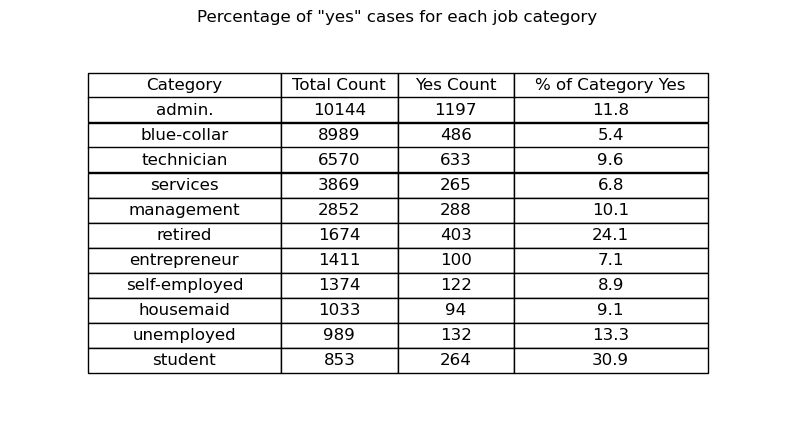

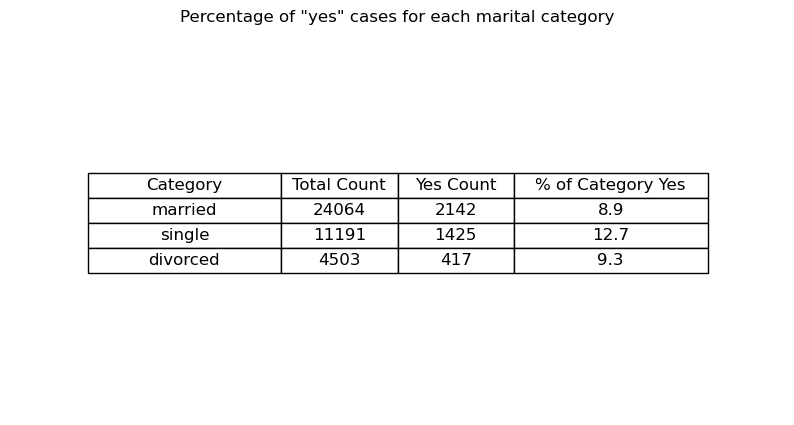

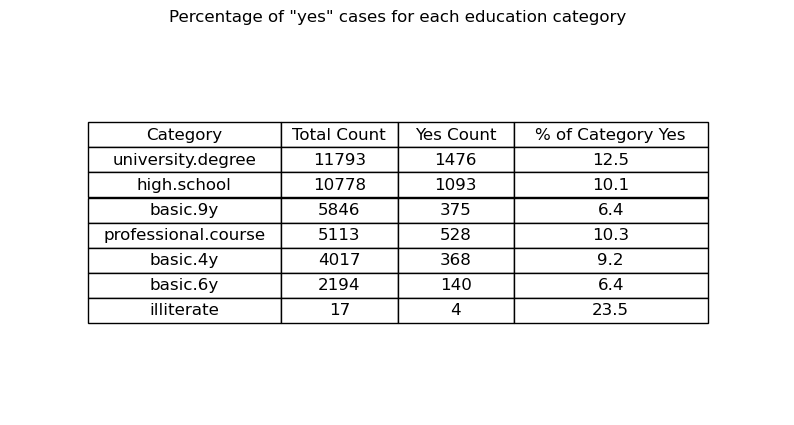

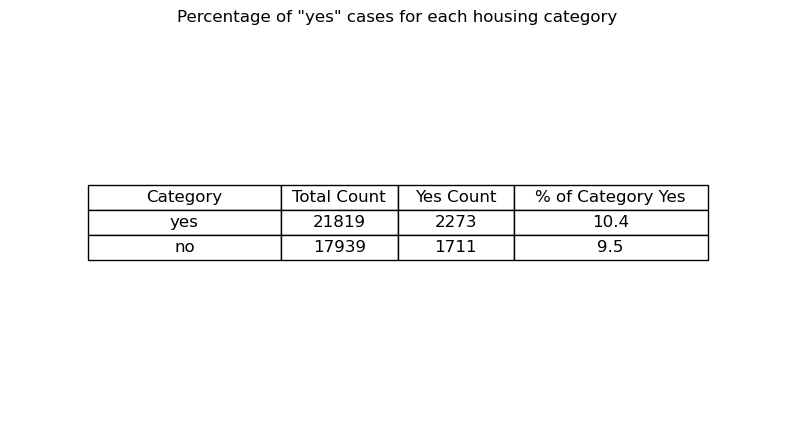

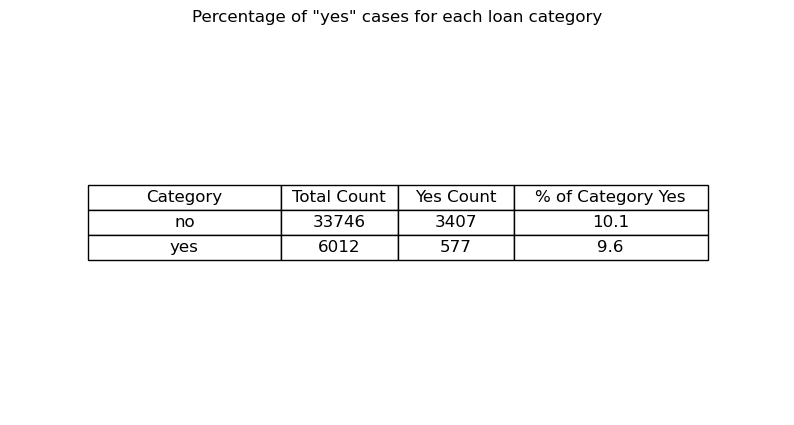

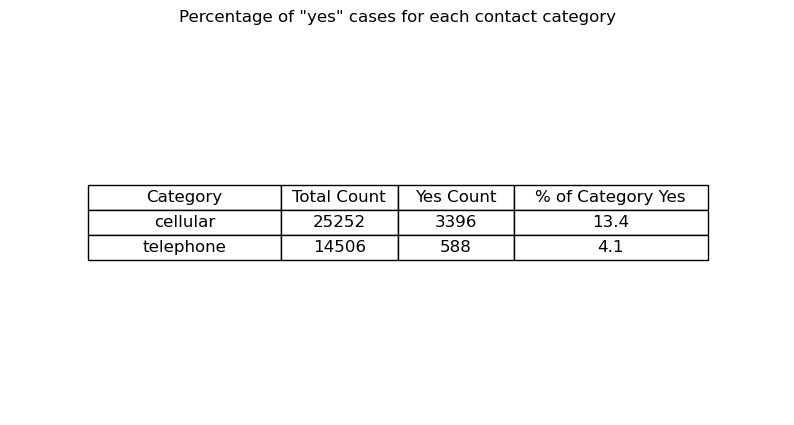

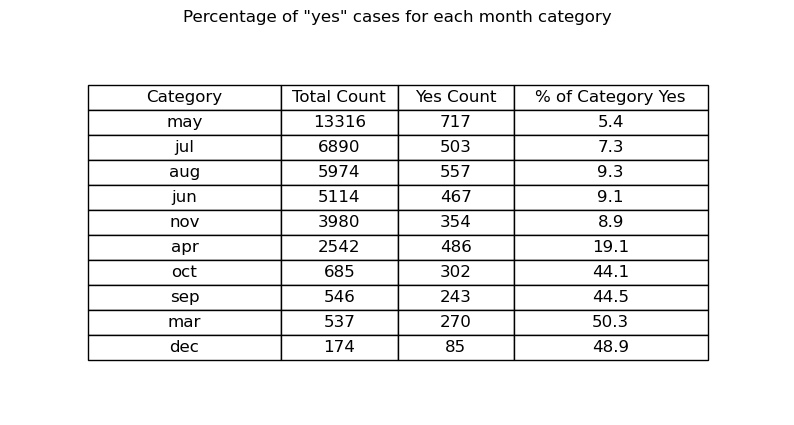

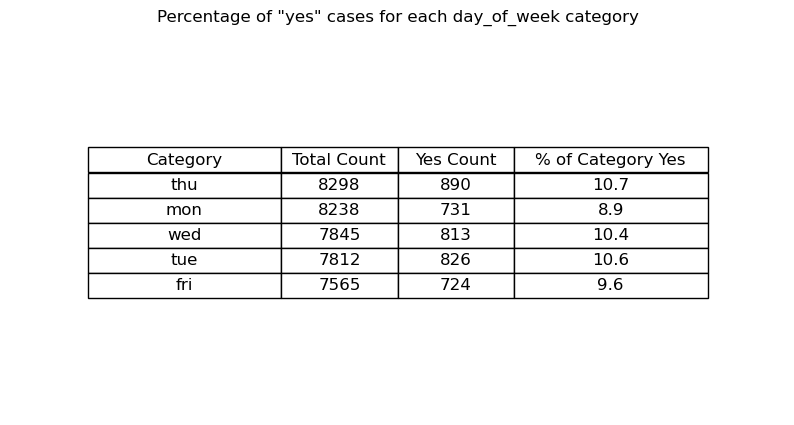

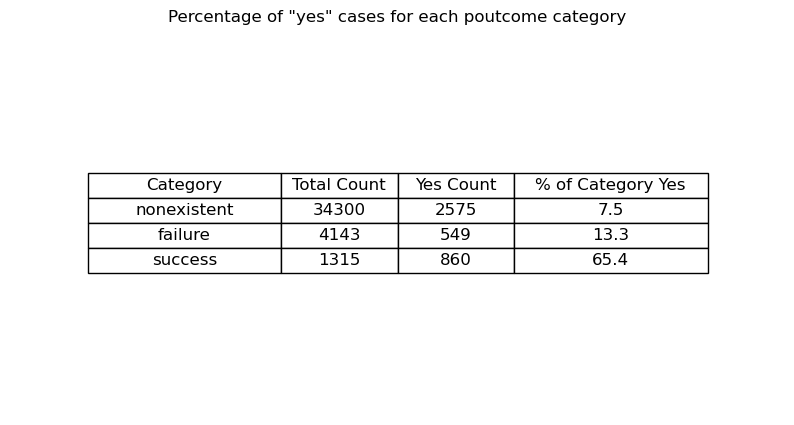

In [29]:
categorical_features = ['job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

for feature in categorical_features:
    category_counts = df[feature].value_counts()
    categories = category_counts.index
    total_counts = category_counts.values
    yes_counts = df[df['y'] == 'yes'][feature].value_counts()
    yes_counts = yes_counts.reindex(categories, fill_value=0)  # Reindex to match category order
    percentages = round((yes_counts / category_counts * 100),1)

    fig, ax = plt.subplots(figsize=(10, 5))
    table_data = np.column_stack((categories, total_counts, yes_counts, percentages))
    column_labels = ['Category', 'Total Count', 'Yes Count', '% of Category Yes']

    table = plt.table(cellText=table_data, colLabels=column_labels, loc='center', cellLoc='center', colWidths=[0.25, 0.15, 0.15, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)

    ax.axis('off')
    plt.title(f'Percentage of "yes" cases for each {feature} category')

    plt.show()



Observations of the data:

Call volume is very high between April and August, but the sales conversion rate is below average for the data. Conversely between Sept and Mar, call volume is quite low but the conversion rate is more than 4x's higher than average for the data (~45%). This would suggest a change in the sales campaign schedule could be highly beneficial, particularly in the winter months.

Certain categories are associated with higher conversion rates. Look at the difference between blue collar workers and retirees: Each category contributed a comparable number of sales conversions (~450), but the the number of retirees contacted compared to blue-collar workers in substantially lower (only 1674 vs 8989), implying retirees are far more likely to purchase the product. Future marketing campaigns should target those customer bases more likely to bring sales conversions.